# Zaitsev Anton | Exercise 3

## General Information

In this exercise we will analyze different graph models. We will generate a number of randomly generated graphs based on **Watts-Strogatz**, **Scale-free** and **Barabási-Albert** models and compare them with real *Facebook* and *Twitter* social networks. The analysis is performed with the help of the *networkx* library in Python, and the analysis includes:
1. Generating $9$ graphs based on **Watts-Strogatz** model with three varying values for $\overline{k}$ and $p$ and plotting graph structures, degree distributions and clustering coefficients.
2. Generating $3$ **Scale-free** graphs with three different values for $\gamma$ and plotting graph structures, degree distributions and clustering coefficients.
3. Generating $9$ graphs based on **Barabási-Albert** model with three different values for $m_0$ and $m$ and plotting graph structures, degree distributions and clustering coefficients.
4. Comparing *Facebook* and *Twitter* networks with the randomly generated graphs in $1,2$ and $3$.

In [31]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, List, Dict, Union, Tuple
from itertools import product
from scipy.spatial.distance import jensenshannon

# global variables
DATA_FOLDER = "../data/"

def construct_graph(edges_path: str, directed: bool = False) -> nx.Graph:
    """
    Construct a graph from an edge list.

    Parameters:
        - edges_path (str): The path to the .edges file, which contains the edges of the graph.
        - directed (bool): If True, the graph will be treated as directed, creating a NetworkX DiGraph.
    
    Returns:
        - g (nx.Graph or nx.DiGraph): A NetworkX graph containing all the nodes and edges from the .edges file.
                                      Additionally, nodes present in the .feat file but missing in the .edges
                                      file will be added to the graph as disconnected nodes (without any edges).
    """
    # read graph from .edges file
    if directed:
        g = nx.read_edgelist(edges_path, create_using=nx.DiGraph(), nodetype=int)
    else:
        g = nx.read_edgelist(edges_path, create_using=nx.Graph(), nodetype=int)
    return g

In [32]:
# load facebook network, indirected graph
G_fb = construct_graph(edges_path=f"{DATA_FOLDER}3437.edges", directed=False)
# load twitter network, directed graph
G_tw = construct_graph(edges_path=f"{DATA_FOLDER}3253671.edges", directed=True)

In [33]:
N = G_fb.number_of_nodes()

## Helper Functions

In [34]:
def plot_graph(graph: nx.Graph, ax) -> None:
    """
    Plots the structure of the given graph using spring layout.

    Parameters:
        - graph (networkx.Graph): The graph to plot.
        - ax (matplotlib.axes.Axes): The axis to plot on.
    """
    pos = nx.spring_layout(graph)  # spring layout for better visualization of graph structure
    nx.draw(graph, pos, ax=ax, with_labels=False, node_size=30, node_color="#0b8494", edge_color="gray", alpha=0.7)

def plot_degree_distribution(graph: nx.Graph, ax) -> None:
    """
    Plots the degree distribution of the given graph.

    Parameters:
        - graph (networkx.Graph): The graph whose degree distribution to plot.
        - ax (matplotlib.axes.Axes): The axis to plot on.
    """
    # get degree of each node
    degrees = [graph.degree(n) for n in graph.nodes()]
    # count occurrences of each degree
    unique_degrees, counts = np.unique(degrees, return_counts=True)
    ax.bar(unique_degrees, counts, width=0.80, color="#125b9a", alpha=0.7)

def plot_clustering_coefficients(graph: nx.Graph, ax) -> None:
    """
    Plots the distribution of clustering coefficients in the given graph.

    Parameters:
        - graph (networkx.Graph): The graph whose clustering coefficients to plot.
        - ax (matplotlib.axes.Axes): The axis to plot on.
    """
    # get the clustering coefficient for each node
    clustering_coeffs = nx.clustering(graph).values()
    ax.hist(list(clustering_coeffs), bins=30, color="#f05a7e", alpha=0.7)

def generate_graph_and_plot(graph_function: Callable[..., nx.Graph], params: List, axs, col_idx: int) -> nx.Graph:
    """
    Generates a graph using the provided graph generation function and parameters.
    Plots the graph structure, degree distribution, and clustering coefficients on the provided axes.
    
    Parameters:
        - graph_function (Callable[..., nx.Graph]): Function that generates nx.Graph.
        - params (List): List of parameters to pass to the graph generation function.
        - axs (list): List of axes for plotting.
        - col_idx (int): The column index in the grid for plotting.
    
    Returns:
        - graph (nx.Graph): Generated graph.
    """
    # generate the graph
    graph = graph_function(*params)
    # plot graph structure
    plot_graph(graph, axs[0, col_idx])
    # plot degree distribution
    plot_degree_distribution(graph, axs[1, col_idx])
    # plot clustering coefficients
    plot_clustering_coefficients(graph, axs[2, col_idx])
    return graph

def generate_and_plot_all_graphs(graph_function: Callable[..., nx.Graph], params_list: List[Dict[str, List]], n: int, title: str) -> Tuple[List[nx.Graph], List[Tuple], List[str]]:
    """
    Root function that generates and plots multiple graphs in a grid layout.
    
    Parameters:
        - graph_function (Callable[..., nx.Graph]): The function to generate graphs.
        - params_list (List[Dict[str, List]]): A list of dictionaries where each dictionary contains the parameter name as the key and the parameter values as the list.
        - n (int): Number of nodes for the graph.
        - title (str): Title of the plot.
    
    Returns:
        - Tuple[
            graphs (List[nx.Graph]): List of generated graphs,
            param_combinations (List[Tuple]): List of all parameter combinations,
            param_names (List[str]): Input parameter names
        ]
    """
    graphs = []
    # extract parameter names and values from the list of dictionaries
    param_names = [list(d.keys())[0] for d in params_list]
    param_values = [list(d.values())[0] for d in params_list]
    # calculate the number of total combinations
    param_combinations = list(product(*param_values))
    num_combinations = len(param_combinations)
    # create a grid of subplots (3 rows, num_combinations columns)
    fig, axs = plt.subplots(3, num_combinations, figsize=(32, 24))
    fig.tight_layout(pad=10)
    fig.subplots_adjust(wspace=0.2, hspace=0.2)
    # add titles & descriptors
    fig.text(0.5, 0.99, title, ha="center", va="center", fontsize=56, fontweight="bold")
    fig.text(0.5, 0.93, "Graph Structures", ha="center", va="center", fontsize=32, fontweight="heavy")
    fig.text(0.5, 0.65, "Degree Distributions", ha="center", va="center", fontsize=32, fontweight="heavy")
    fig.text(0.5, 0.336, "Clustering Coefficient Distributions", ha="center", va="center", fontsize=32, fontweight="heavy")
    fig.text(0.5, 0.357, "Degree", ha="center", va="center", fontsize=24, fontweight="light")
    fig.text(0.5, 0.045, "Clustering Coefficient", ha="center", va="center", fontsize=24, fontweight="light")
    fig.text(0.035, 0.496, "Number of Nodes", ha="center", va="center", rotation="vertical", fontsize=24, fontweight="light")
    fig.text(0.035, 0.1675, "Number of Nodes", ha="center", va="center", rotation="vertical", fontsize=24, fontweight="light")
    # loop through all parameter combinations and set titles for each column
    for col_idx, param_combination in enumerate(param_combinations):
        # create a column title based on the current parameter combination
        column_title = ', '.join(f"{name}={value}" for name, value in zip(param_names, param_combination))
        # set the title above the column
        axs[0, col_idx].set_title(column_title, fontsize=24, pad=20)
        # generate and plot the graph for the current combination of parameters
        graph = generate_graph_and_plot(graph_function=graph_function, params=[n] + list(param_combination), axs=axs, col_idx=col_idx)
        graphs.append(graph)
    plt.show()
    return (graphs, param_combinations, param_names)

## Question **a**: Watts-Strogatz Model

### Algorithm

1. Start with a ring lattice with $N$ nodes, in which every node is connected to its first $\overline{k}$ neighbours ($\frac{\overline{k}}{2}$ on either size).
2. Randomly rewire each edge of the lattice with probability $p$ (self-connections and duplicate edges are excluded).

We will use *networkx* `watts_strogatz_graph()` function to generate random graphs with varying parameters.

In [35]:
def generate_ws(n: int, k: int, p: float) -> nx.Graph:
    """
    Generates random graph based on Watts-Strogatz model.
    
    Parameters:
        - n (int): Number of nodes.
        - k (int): number of nearest neighbors in a ring topology.
        - p (float): The probability of rewiring each edge.
    """
    graph = nx.watts_strogatz_graph(n=n, k=k, p=p)
    return graph

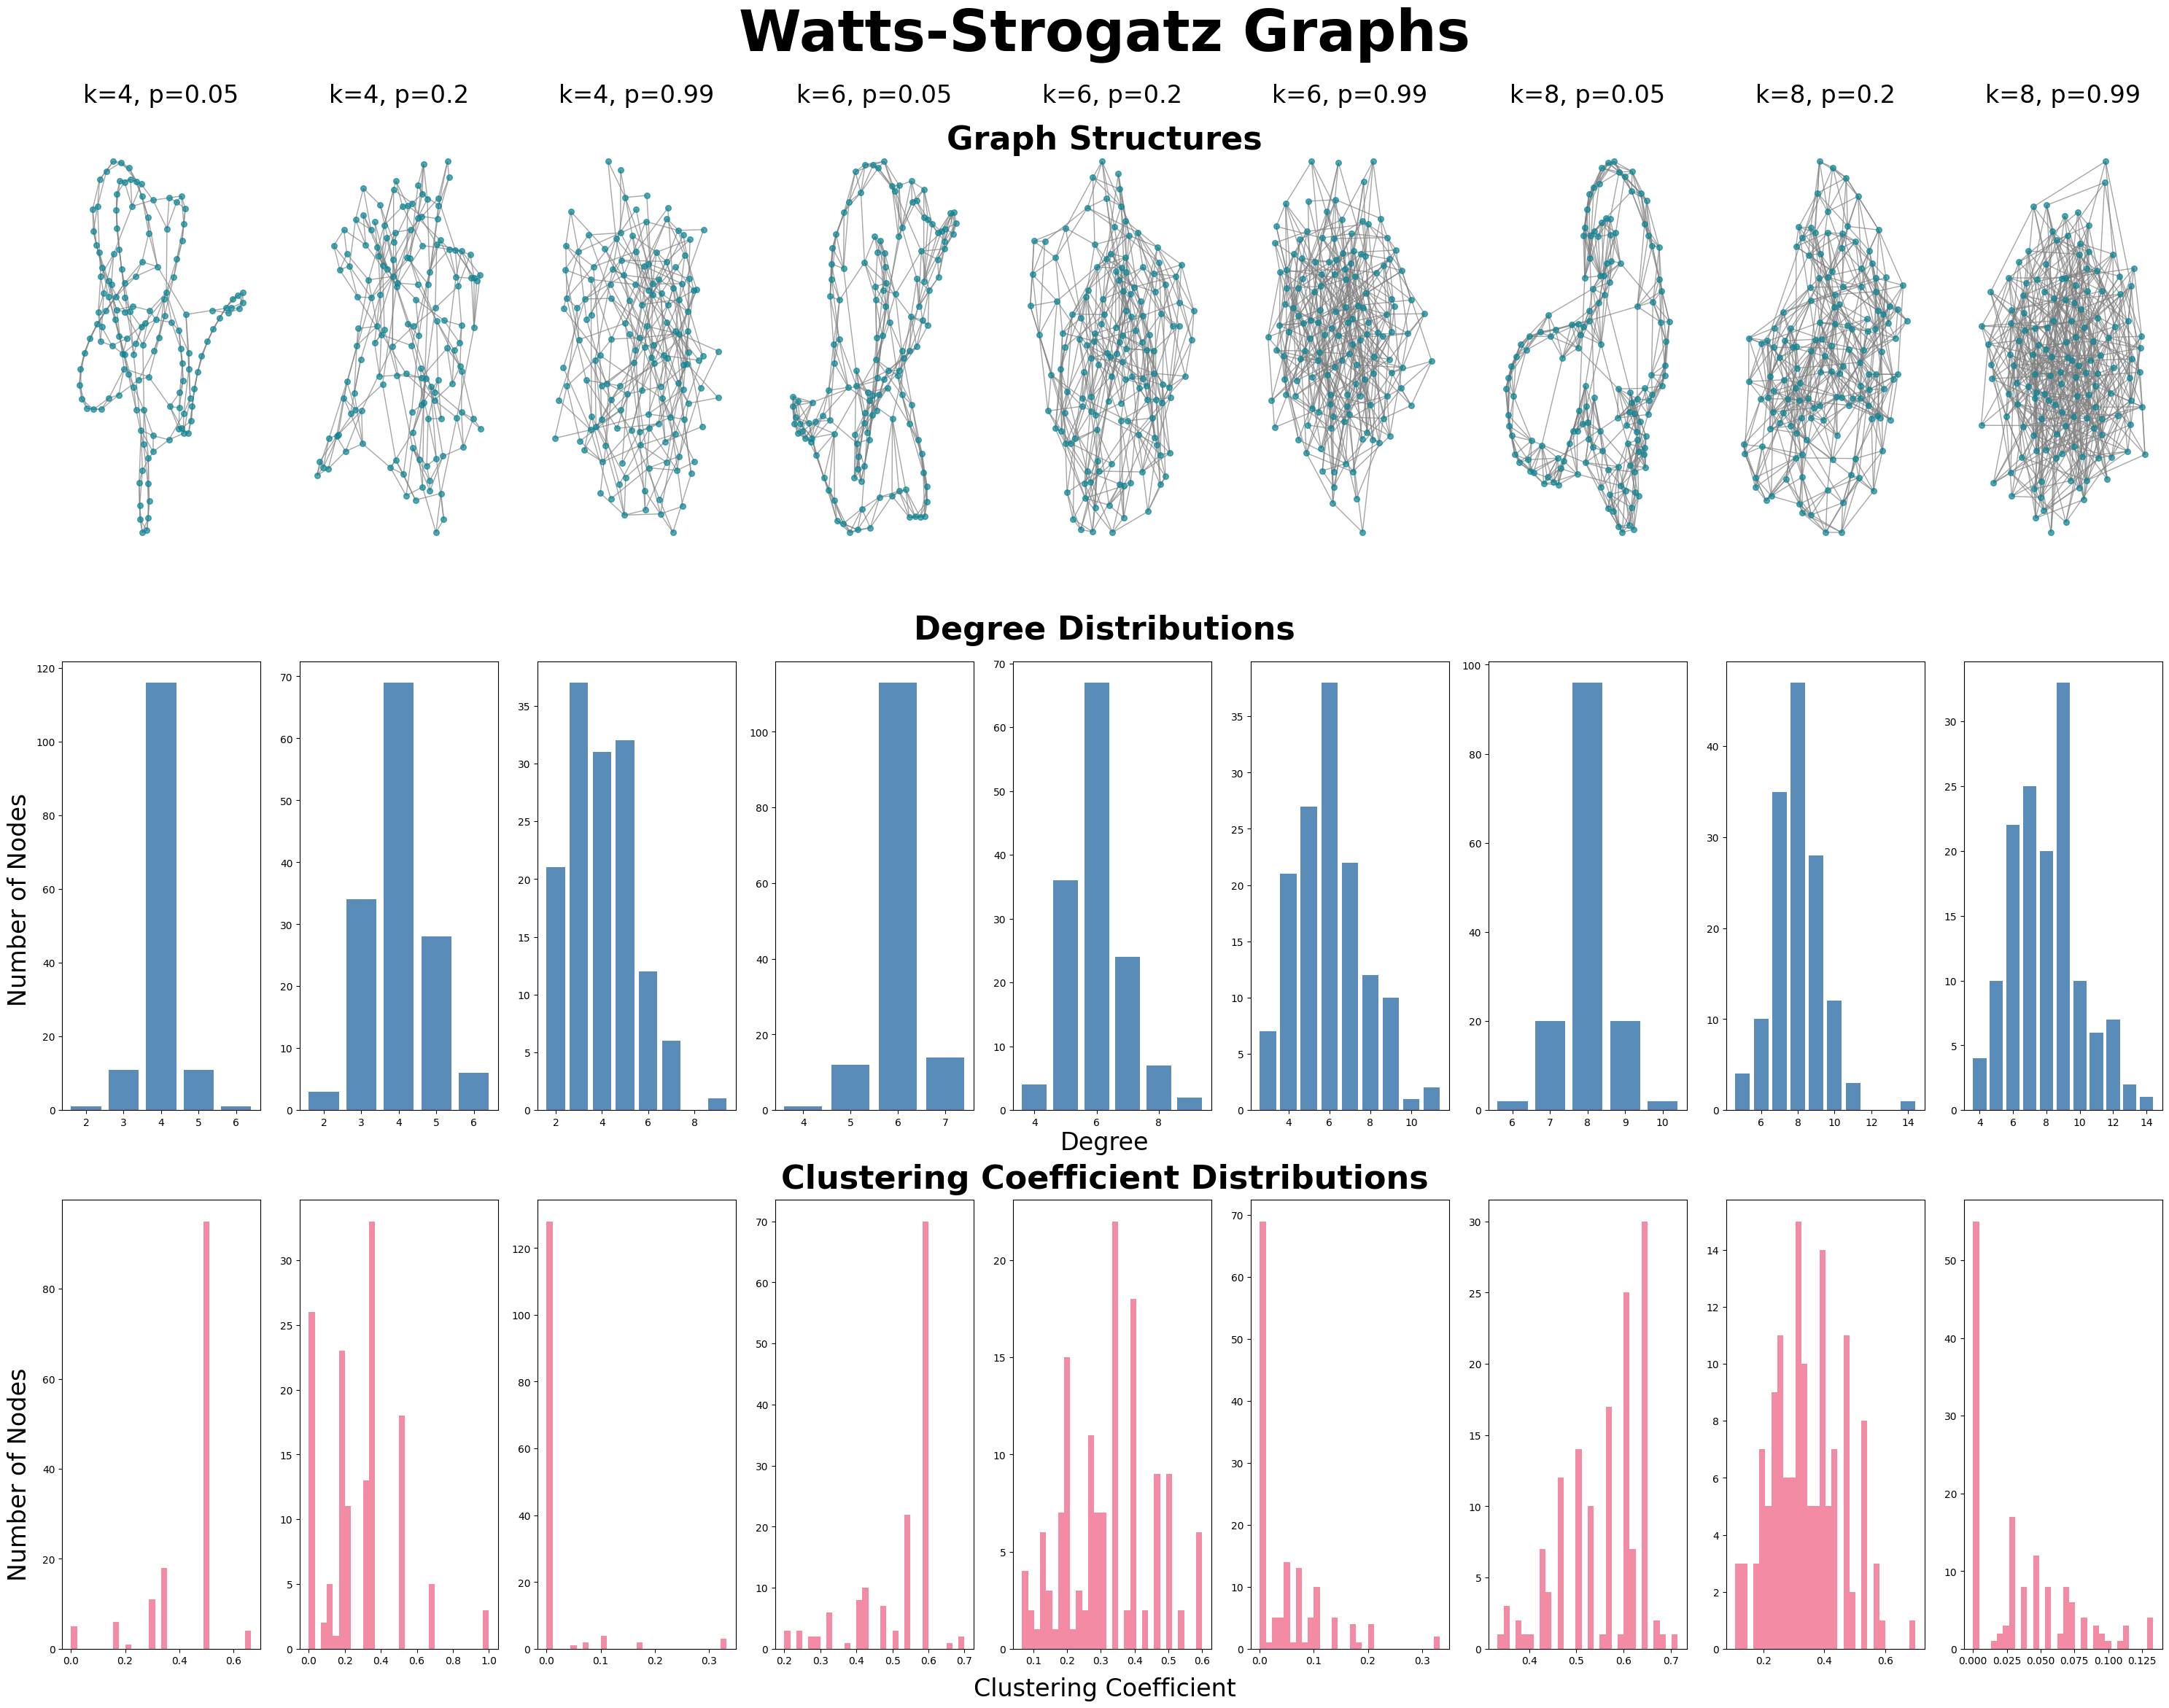

In [36]:
params_list = [
    {"k": [4, 6, 8]},
    {"p": [0.05, 0.2, 0.99]}
]
ws_graphs, ws_param_combinations, ws_param_names = generate_and_plot_all_graphs(
    graph_function=generate_ws, 
    params_list=params_list,
    n=N,
    title="Watts-Strogatz Graphs"
)

## Question **b**: Scale-free Model

The main property of a scale-free model is the fact that its degree distribution follows (to some extent) **Power-law** distribution:

$$P(k) \approx \frac{k^{-\gamma}}{\zeta(\gamma)}, \gamma - \text{exponent of the distribution}$$

### Algorithm

1. Use `np.random.zipf()` to generate a degree sequence that follows power-lar distribution.
2. Generate a graph from this degree sequence.

In [37]:
def generate_pw_degree_sequence(n: int, gamma: float) -> np.ndarray:
    """
    Generate degrees that follow a power-law distribution.
    We use xmin=1 (the smallest degree) and xmax=n (the largest degree)

    Parameters:
        - n (int): Number of nodes in the graph.
        - gamma (float): Distribution parameter.
    
    Returns:
        - degrees (ndarray): Drawn samples from the parameterized Zipf distribution.
    """
    degrees = np.random.zipf(gamma, size=n)
    return degrees

def generate_sf(n: int, gamma: float) -> nx.Graph:
    """
    Generate random graph with degrees following a power-law distribution, i.e. scale-free graph.

    Parameters:
        - n (int): Number of nodes in the graph.
        - gamma (float): Distribution parameter.
    
    Returns:
        - graph (ndarnx.Graph): Random graph with degrees following a power-law distribution.
    """
    degree_seq = generate_pw_degree_sequence(n=n, gamma=gamma)
    # ensure that the sum of degrees is even (necessary for graph generation)
    if sum(degree_seq) % 2 != 0:
        degree_seq[0] += 1
    # create graph using configuration model: generate random graph that exactly match a given degree sequence
    graph = nx.configuration_model(degree_seq)
    # remove parallel edges and self-loops introduced by the configuration model
    graph = nx.Graph(graph)  # convert to simple graph
    graph.remove_edges_from(nx.selfloop_edges(graph))
    return graph

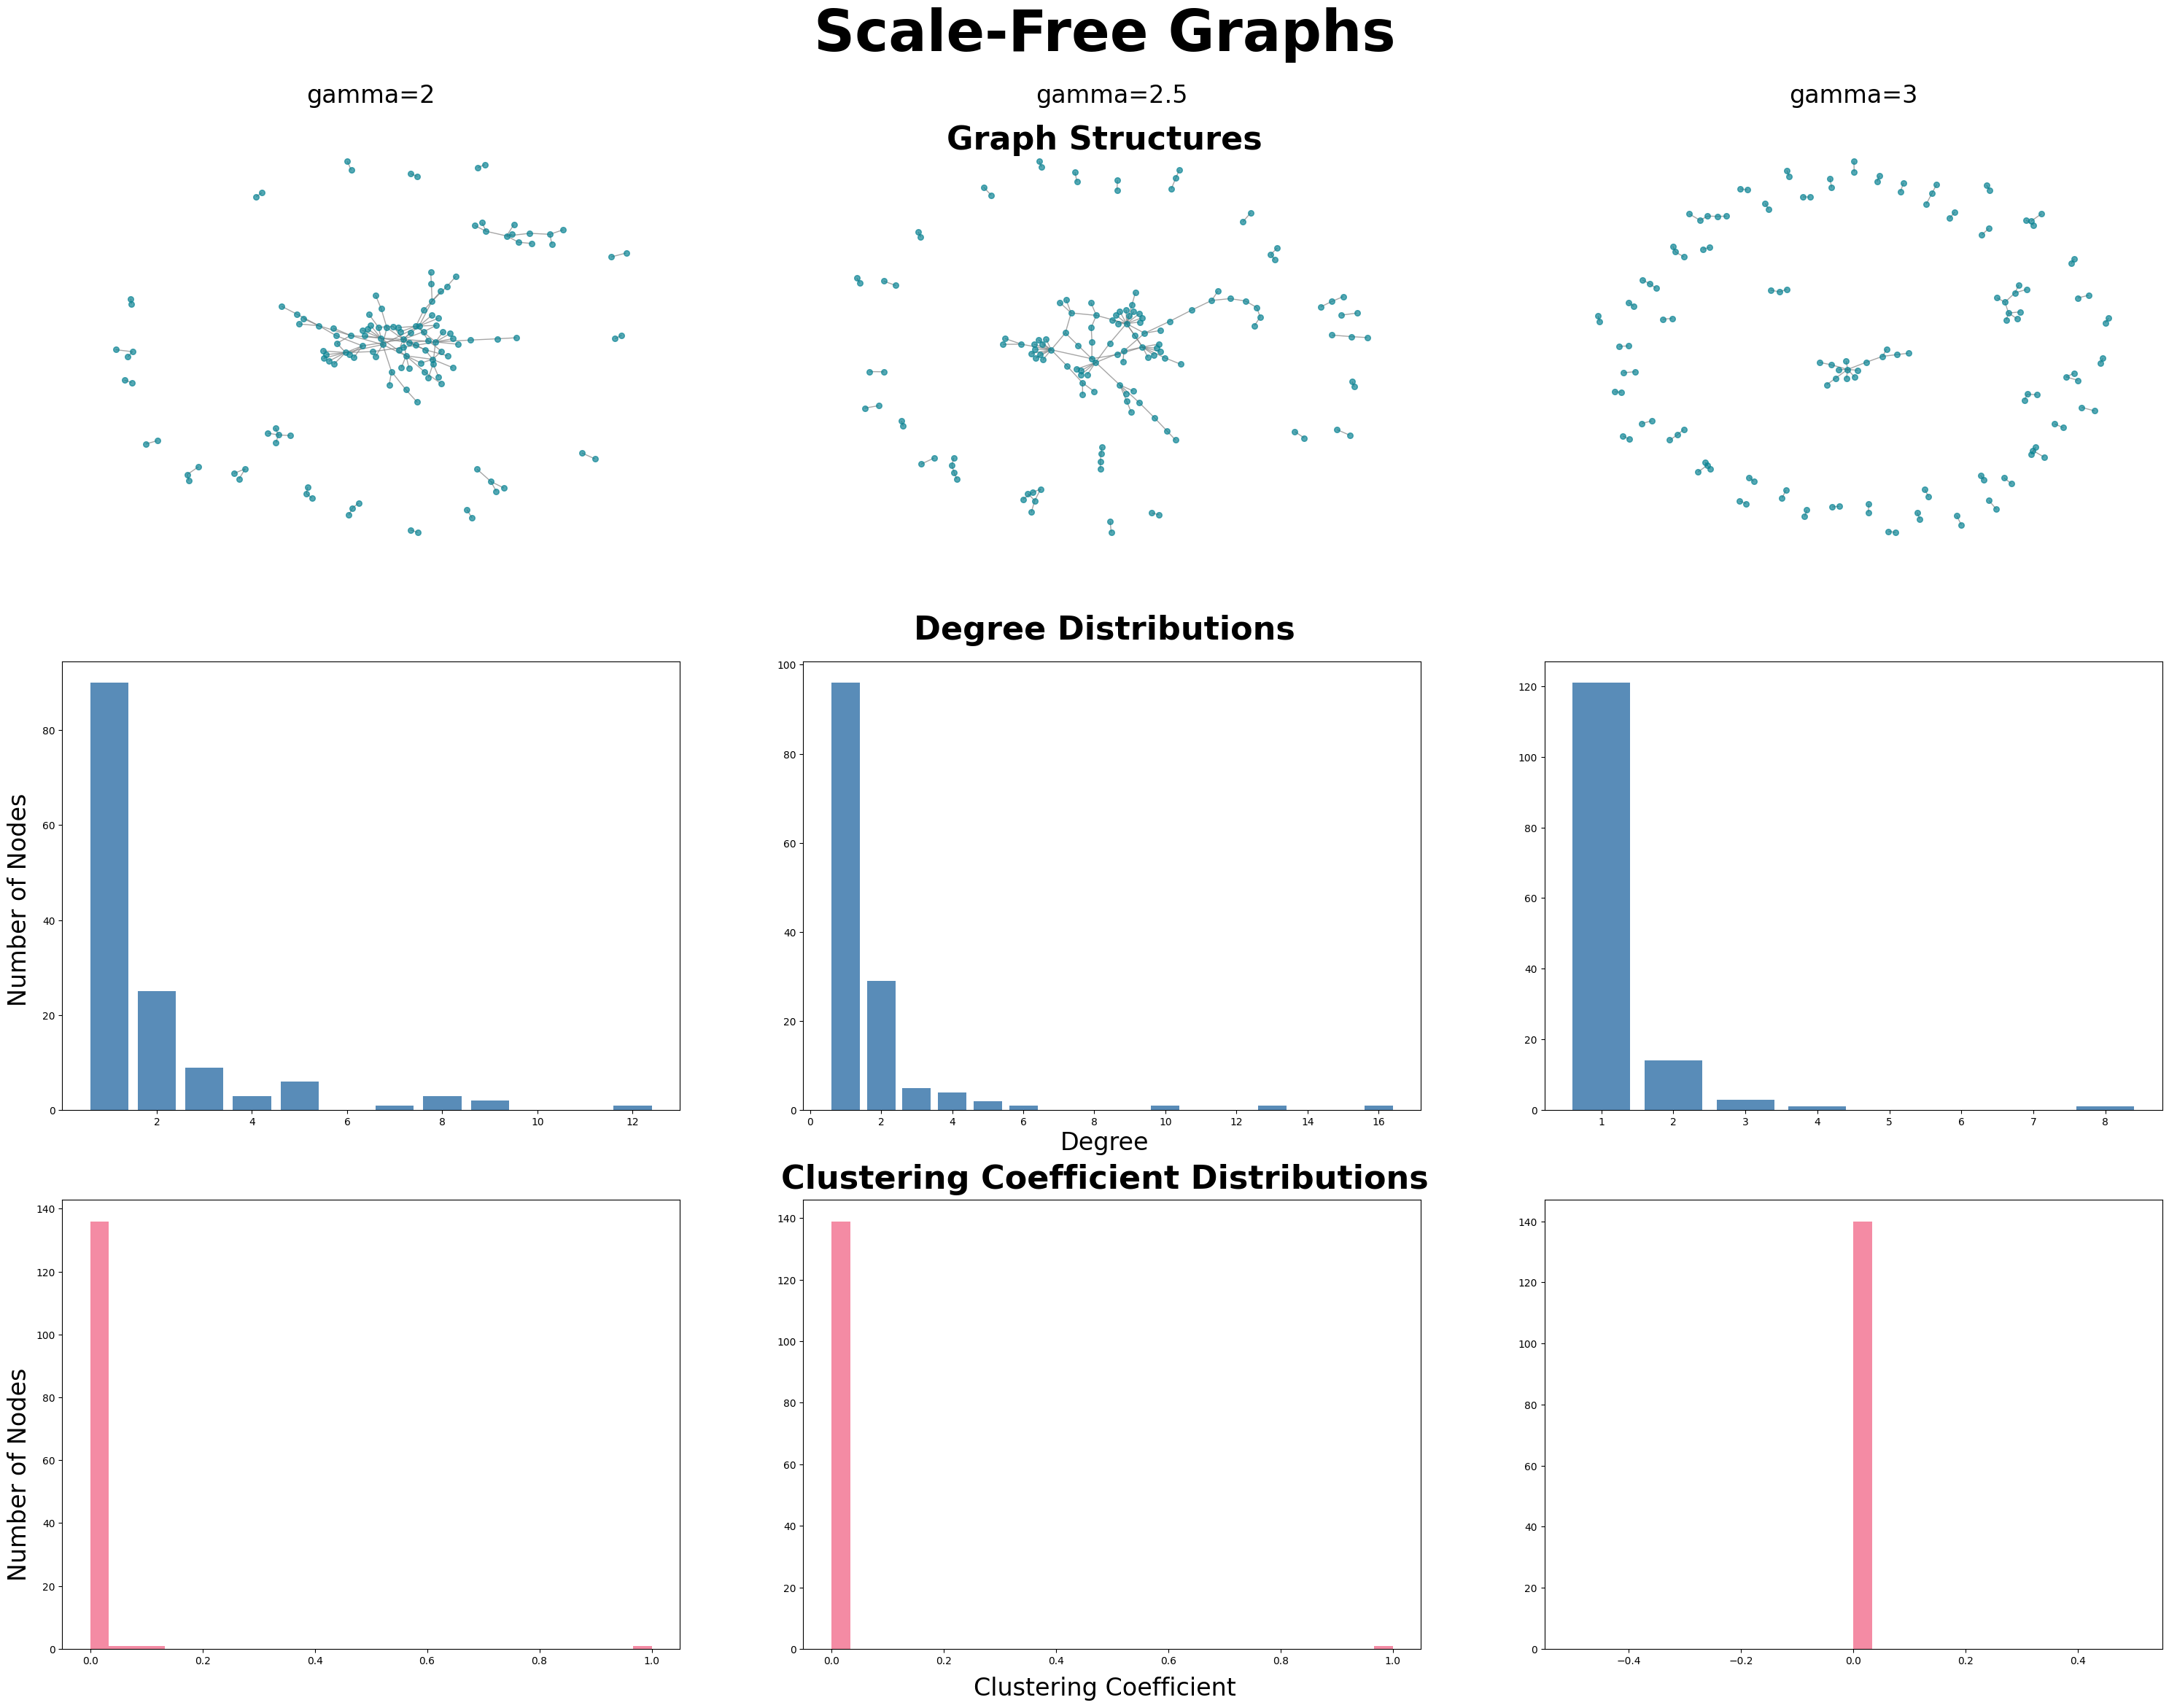

In [38]:
params_list = [
    {"gamma": [2, 2.5, 3]},
]
sf_graphs, sf_param_combinations, sf_param_names = generate_and_plot_all_graphs(
    graph_function=generate_sf, 
    params_list=params_list,
    n=N,
    title="Scale-Free Graphs"
)

## Question **c**: Barabási-Albert Model

### Algorithm

1. Start with $m_0$ connected nodes.
2. At each time step we add a new node with $m (\le m_0)$ links that connect it to $m$ nodes already in the network.
3. The probability $P(k)$ that one of the links of the new node connects to node $i$ depends on its degree $k_i$ as $P(k)=\frac{k_i}{\sum_jk_j}$

We will use *networkx* `barabasi_albert_graph()` function to generate random graphs with varying parameters.

In [39]:
def generate_m0(n: int, graph_type: str = "complete") -> nx.Graph:
    """
    Generates an initial graph with the given size and type.
    
    Parameters:
        - n (int): The number of nodes for the m0 graph.
        - graph_type (str): The type of graph to generate ("complete", "random", "lattice").
    
    Returns:
        - (nx.Graph): Connected initial graph (m0).
    """
    if graph_type == "complete":
        return nx.complete_graph(n) # fully connected graph with n nodes
    elif graph_type == "random":
        return nx.gnp_random_graph(n, p=0.5)  # random graph with edge probability p
    elif graph_type == "lattice":
        return nx.grid_2d_graph(int(np.sqrt(n)), int(np.sqrt(n)))  # 2D grid (lattice)
    else:
        raise ValueError(f"Unknown graph_type: {graph_type}")

def generate_ba(n: int, m: int, n_m0: int) -> nx.Graph:
    """
    Generates random graph based on Barabasi-Albert model.
    
    Parameters:
        - n (int): Number of nodes.
        - m (int): Number of edges to attach from a new node to existing nodes.
        - n_m0 (int): Number of notes for the initial network for Barabási-Albert algorithm. 
    """
    m0 = generate_m0(n=n_m0, graph_type="random")
    graph = nx.barabasi_albert_graph(n=n, m=m, initial_graph=m0)
    return graph

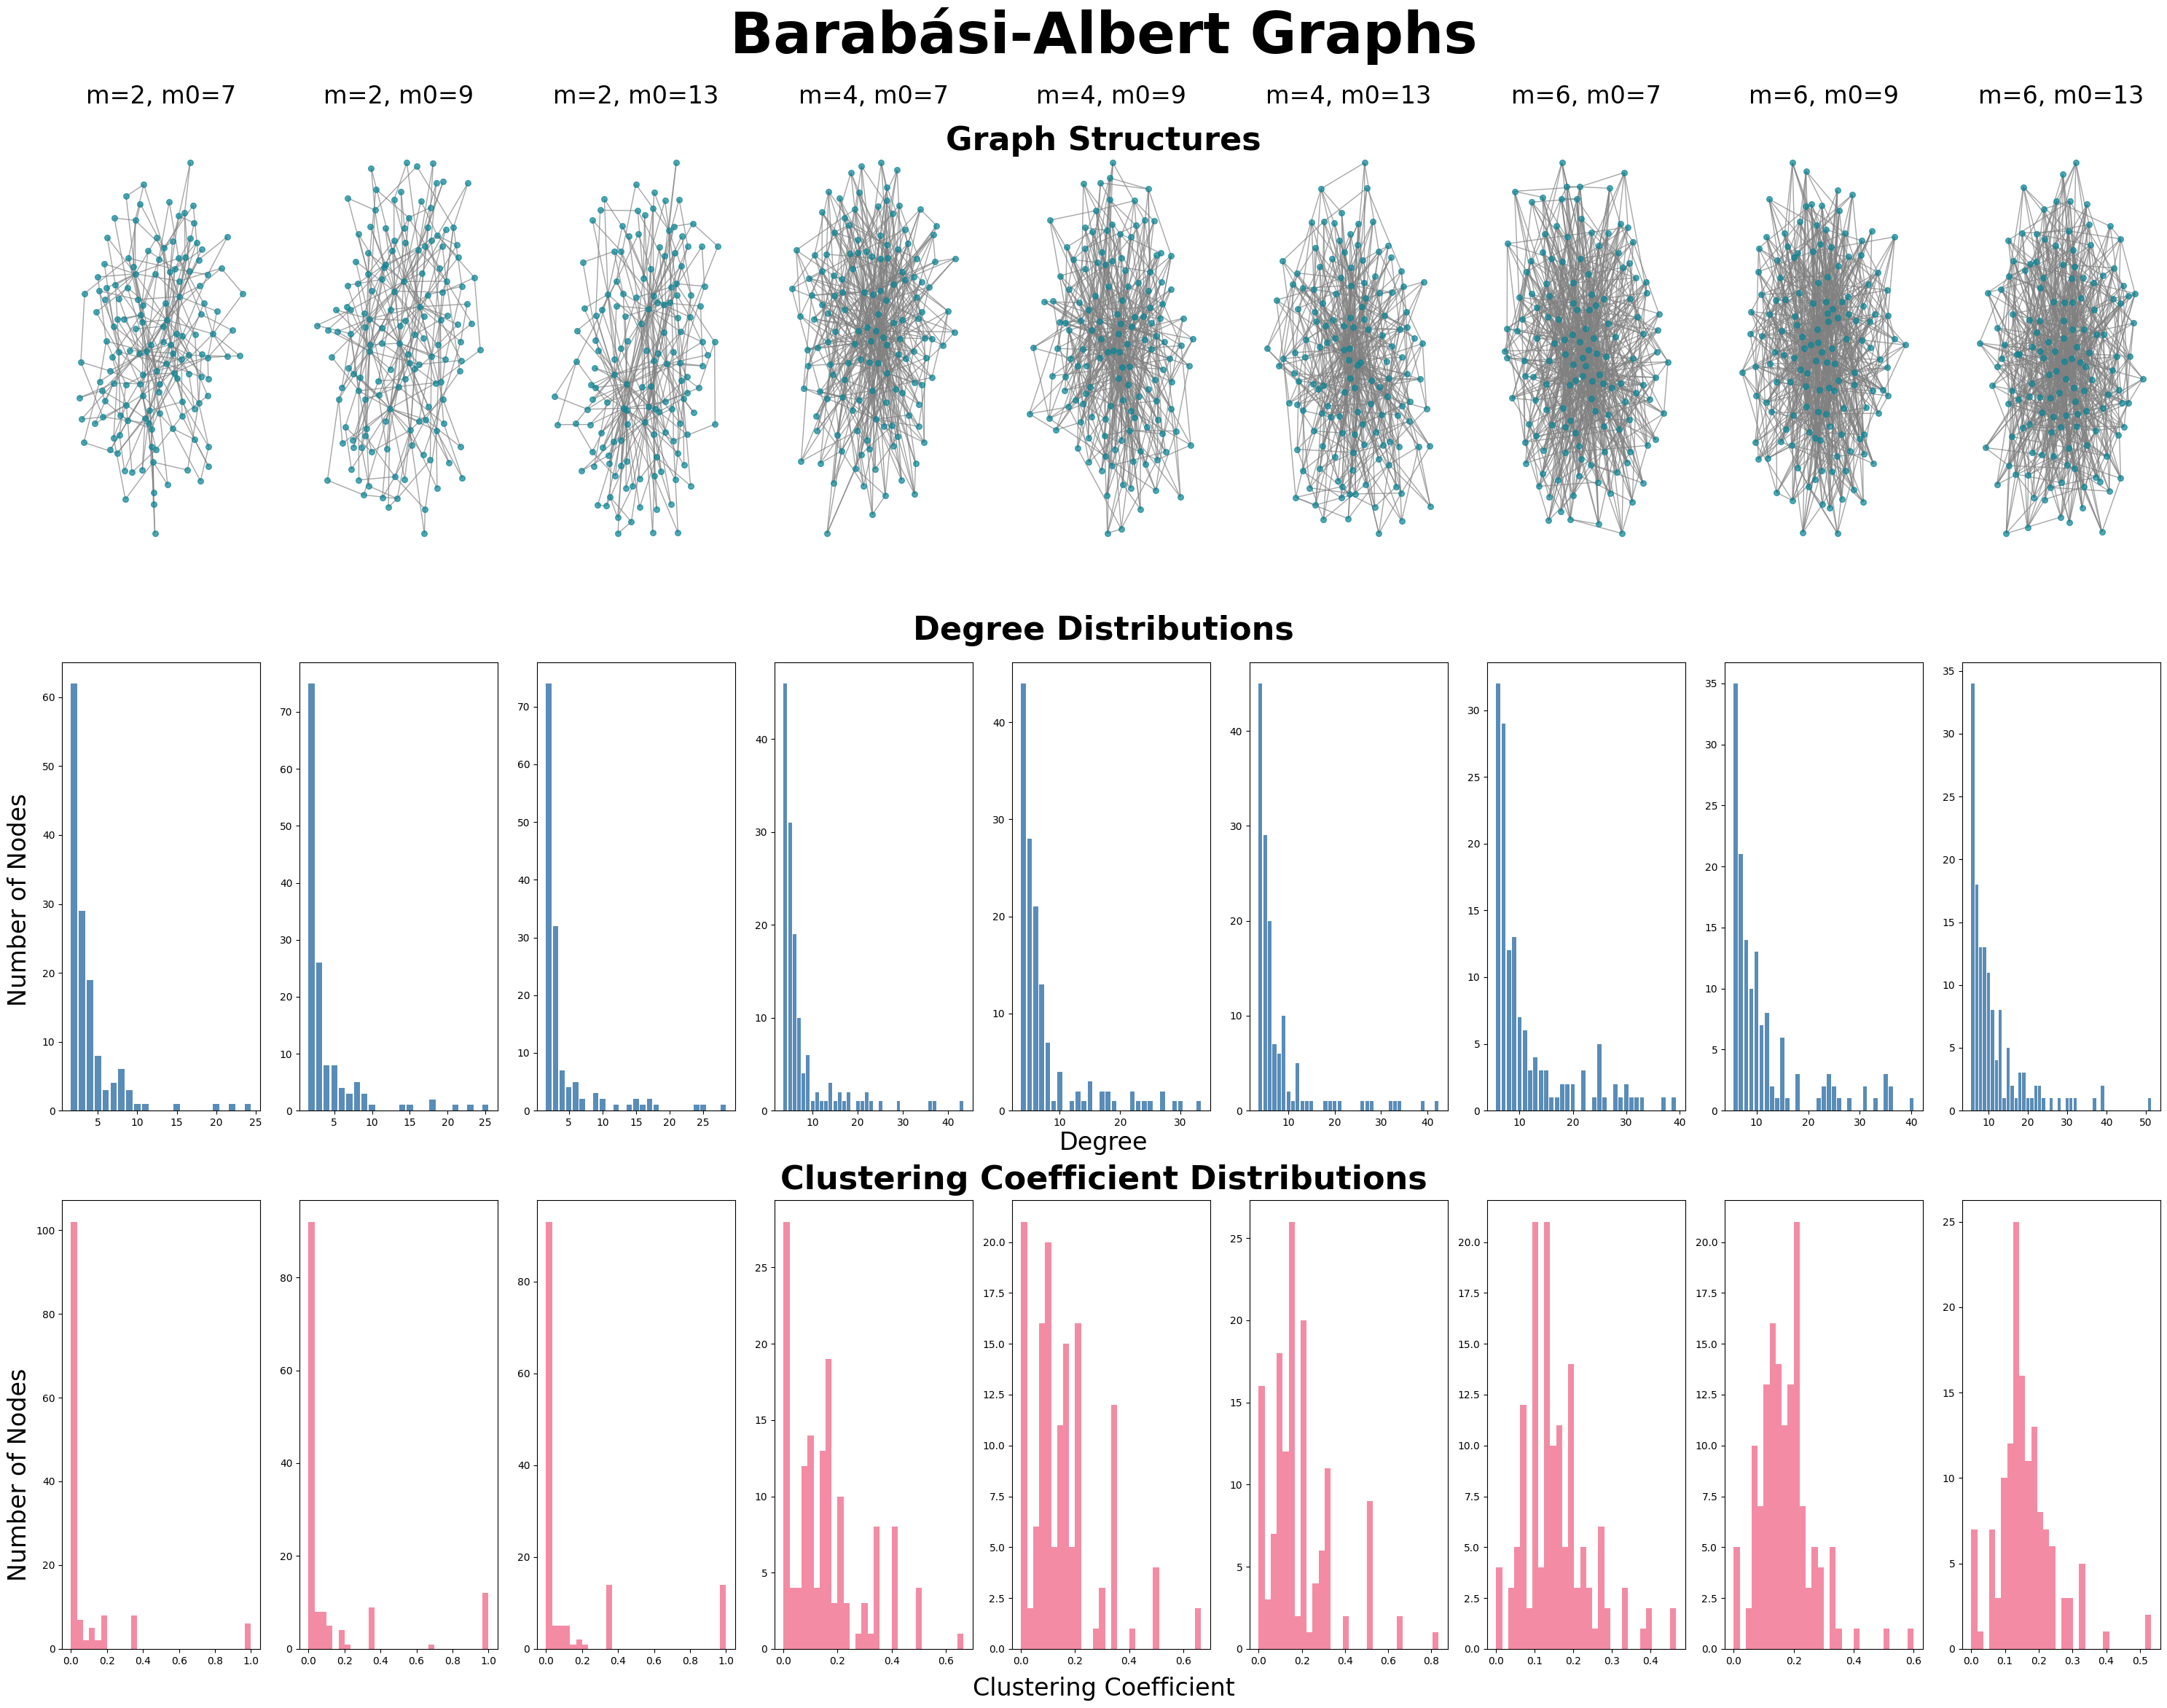

In [40]:
params_list = [
    {"m": [2, 4, 6]},
    {"m0": [7, 9, 13]}
]
ba_graphs, ba_param_combinations, ba_param_names = generate_and_plot_all_graphs(
    graph_function=generate_ba, 
    params_list=params_list,
    n=N,
    title="Barabási-Albert Graphs"
)

## Question **d**: Comparison with Real Social Networks

To find the graph among our randomly generated graphs that is the most similar to *Facebook* and *Twitter* networks, we will need to compare the **Degree** **Distribution**, **Clustering** **Coefficient** **Distribution**, and potentially additional metrics such as **Shortest** **Path** **Length** **Distribution**.

For the distribution comparison we will use *Symmetric Kullback-Leibler Divergence (Jensen-Shannon Divergence)*, a symmetrized and smoothed version of Kullback-Leibler divergence.

We have:
- `G_fb`: Facebook graph.
- `G_tw`: twitter graph.
- `ws_graphs`: list of *BA* graphs.
- `sf_graphs`: list of *BA* graphs.
- `ba_graphs`: list of *BA* graphs.

In [41]:
def get_distribution(data: List[int]) -> np.ndarray:
    """
    Calculates the distribution from a list of values.

    Parameters:
        - data (List[int]): Input list of data.
    
    Returns:
        - (np.ndarray): Distribution.
    """
    # count the number of unique values
    values, counts = np.unique(data, return_counts=True)
    # normalize to get the distribution
    distribution = counts / counts.sum()
    return distribution

def compute_jsd(distribution1: np.ndarray, distribution2: np.ndarray) -> float:
    """
    Computes the symmetric Kullback-Leibler divergence between two distributions.

    Parameters:
        - distribution1 (np.ndarray): First distribution array.
        - distribution2 (np.ndarray): Second distribution array.
    
    Returns:
        (float): Jensen-Shannon distance between two probability arrays.
    """
    return jensenshannon(distribution1, distribution2)

def average_shortest_path_length(graph: nx.Graph, normalize: bool = True) -> float:
    """
    Calculates average shortest path length of a given network.
    
    Parameters:
        - graph (networkx.Graph): The input graph.
    
    Returns:
        - (float): average path length of a given network.
    """
    # identify connected / strongly connected components
    if isinstance(graph, nx.DiGraph):
        components = [graph.subgraph(c).copy() for c in nx.strongly_connected_components(graph)]
    else:
        # check if the graph is connected
        if nx.is_connected(graph):
            return nx.average_shortest_path_length(graph)
        components = [graph.subgraph(c).copy() for c in nx.connected_components(graph)]
    # use method 2 to calculate average path length
    total_pairs = 0
    total_weighted_path_length = 0
    for component in components:
        n = component.number_of_nodes()
        if n > 1:
            # number of pairs in this component
            num_pairs = n * (n - 1) if isinstance(graph, nx.DiGraph) else n * (n - 1) / 2
            # average path length for this component
            avg_path_length_component = nx.average_shortest_path_length(component)
            # weighted sum contribution from this component
            total_weighted_path_length += avg_path_length_component * num_pairs
            total_pairs += num_pairs
    # if the graph is completely disconnected, return infinity
    if total_pairs == 0:
        return float('inf')
    # calculate average path length
    avg_path_length = total_weighted_path_length / total_pairs
    # normalize the average path length by dividing by the graph's diameter
    try:
        diameter = nx.diameter(graph)
    except nx.NetworkXError:
        diameter = 1  # if diameter can't be computed, assume it's 1 to avoid division by 0
    if normalize:
        return avg_path_length / diameter if diameter > 0 else avg_path_length
    else:
        return avg_path_length

def graph_similarity(graph: nx.Graph, graph_fb: nx.Graph, graph_tw: nx.Graph,
                     weight_degree: float = 0.4, weight_clustering: float = 0.4, weight_path_length: float = 0.2
                     ) -> float:
    """
    Computes the similarity of a graph to both Facebook and Twitter reference graphs.
    Weighs the similarity between the two reference graphs with a weight of 0.5 each.
    Compares degree distribution, clustering coefficient distribution, and average shortest path length.
    Gives more weight to degree and clustering coefficient distributions.
    
    Parameters:
        - graph (nx.Graph): Input graph.
        - graph_fb (nx.Graph): Facebook graph.
        - graph_tw (nx.Graph): Twitter graph.
    
    Returns:
        - similarity (float): Weighted sum similarity score.
        - total_similarity_fb (float): Similarity score to Facebook.
        - total_similarity_tw (float): Similarity score to Twitter.
    """
    def pad_distributions(dist1, dist2):
        """
        Helper function to pad two distributions to have the same length by filling missing values with 0.
        """
        # determine the maximum length among distribution arrays
        length = max(len(dist1), len(dist2))
        # pad the distributions to the same length with 0s
        padded_dist1 = np.pad(dist1, (0, length - len(dist1)), 'constant')
        padded_dist2 = np.pad(dist2, (0, length - len(dist2)), 'constant')
        return padded_dist1, padded_dist2
    
    def calculate_distributions(graph, graph_fb, graph_tw, func):
        """
        Helper function to compute distributions for graph, Facebook, and Twitter.
        """
        # compute distributions
        dist_graph = get_distribution(func(graph))
        dist_fb = get_distribution(func(graph_fb))
        dist_tw = get_distribution(func(graph_tw))
        # pad distributions to have the same length
        padded_dist_graph_fb, padded_dist_fb = pad_distributions(dist_graph, dist_fb)
        padded_dist_graph_tw, padded_dist_tw = pad_distributions(dist_graph, dist_tw)

        return padded_dist_graph_fb, padded_dist_fb, padded_dist_graph_tw, padded_dist_tw

    # compute degree and clustering coefficient distributions
    degrees_graph_fb, degrees_fb, degrees_graph_tw, degrees_tw = calculate_distributions(
        graph, graph_fb, graph_tw, lambda g: [g.degree(n) for n in g.nodes()]
    )
    clustering_graph_fb, clustering_fb, clustering_graph_tw, clustering_tw = calculate_distributions(
        graph, graph_fb, graph_tw, lambda g: list(nx.clustering(g).values())
    )
    # compute average path lengths
    avg_path_length_graph = average_shortest_path_length(graph)
    avg_path_length_fb = average_shortest_path_length(graph_fb)
    avg_path_length_tw = average_shortest_path_length(graph_tw)
    # compute JSD for degree and clustering coefficient
    jsd_degree_fb, jsd_degree_tw = compute_jsd(degrees_graph_fb, degrees_fb), compute_jsd(degrees_graph_tw, degrees_tw)
    jsd_clustering_fb, jsd_clustering_tw = compute_jsd(clustering_graph_fb, clustering_fb), compute_jsd(clustering_graph_tw, clustering_tw)
    # compute the absolute difference in average path length
    path_diff_fb = abs(avg_path_length_graph - avg_path_length_fb)
    path_diff_tw = abs(avg_path_length_graph - avg_path_length_tw)
    # compute total similarity scores
    total_similarity_fb = (
        weight_degree * jsd_degree_fb + 
        weight_clustering * jsd_clustering_fb + 
        weight_path_length * path_diff_fb
    )
    total_similarity_tw = (
        weight_degree * jsd_degree_tw + 
        weight_clustering * jsd_clustering_tw + 
        weight_path_length * path_diff_tw
    )
    # combine similarities with equal weights for Facebook and Twitter
    similarity = 0.5 * total_similarity_fb + 0.5 * total_similarity_tw
    return similarity, total_similarity_fb, total_similarity_tw

def find_most_similar_graph(ws_inputs: Tuple[List[nx.Graph], List[Tuple], List[str]],
                            sf_inputs: Tuple[List[nx.Graph], List[Tuple], List[str]], 
                            ba_inputs: Tuple[List[nx.Graph], List[Tuple], List[str]],
                            G_fb: nx.Graph, G_tw: nx.Graph) -> Dict[str, Dict[str, Union[str, nx.Graph, Tuple, List[str]]]]:
    """
    Finds the graph that is most similar to both Facebook and Twitter graphs based on 
        degree distribution, clustering coefficient distribution, and average path length.
    """
    all_inputs = [("WS", ws_inputs), ("SF", sf_inputs), ("BA", ba_inputs)]
    
    best_graph_both, best_param_combination_both, best_graph_model_both, best_graph_param_names_both = None, None, None, None
    best_graph_fb, best_param_combination_fb, best_graph_model_fb, best_graph_param_names_fb = None, None, None, None
    best_graph_tw, best_param_combination_tw, best_graph_model_tw, best_graph_param_names_tw = None, None, None, None
    
    best_similarity_score_both = np.inf
    best_similarity_score_fb = np.inf
    best_similarity_score_tw = np.inf
    # combine graphs and parameters into one iterable variable
    all_graphs = [
        (model, graph, param_comb, param_names) 
        for model, (graphs, params, param_names) in all_inputs
        for graph, param_comb in zip(graphs, params)
    ]
    # iterate through all graphs and compute similarity
    for model, graph, param_comb, param_names in all_graphs:
        similarity_score_both, similarity_score_fb, similarity_score_tw = graph_similarity(graph, G_fb, G_tw)
        # check for overall best similarity (combined FB and Twitter)
        if similarity_score_both < best_similarity_score_both:
            best_similarity_score_both = similarity_score_both
            best_graph_both, best_param_combination_both = graph, param_comb
            best_graph_model_both, best_graph_param_names_both = model, param_names
        # check for best Facebook similarity
        if similarity_score_fb < best_similarity_score_fb:
            best_similarity_score_fb = similarity_score_fb
            best_graph_fb, best_param_combination_fb = graph, param_comb
            best_graph_model_fb, best_graph_param_names_fb = model, param_names
        # check for best Twitter similarity
        if similarity_score_tw < best_similarity_score_tw:
            best_similarity_score_tw = similarity_score_tw
            best_graph_tw, best_param_combination_tw = graph, param_comb
            best_graph_model_tw, best_graph_param_names_tw = model, param_names
    # return the best graphs for both networks and individually for FB and Twitter
    return {
        "both": {
            "model": best_graph_model_both, 
            "graph": best_graph_both, 
            "params": best_param_combination_both, 
            "param_names": best_graph_param_names_both
        },
        "fb": {
            "model": best_graph_model_fb, 
            "graph": best_graph_fb, 
            "params": best_param_combination_fb, 
            "param_names": best_graph_param_names_fb
        },
        "tw": {
            "model": best_graph_model_tw, 
            "graph": best_graph_tw, 
            "params": best_param_combination_tw, 
            "param_names": best_graph_param_names_tw
        }
    }

In [42]:
best_graphs = find_most_similar_graph(
    ws_inputs=(ws_graphs, ws_param_combinations, ws_param_names),
    sf_inputs=(sf_graphs, sf_param_combinations, sf_param_names),
    ba_inputs=(ba_graphs, ba_param_combinations, ba_param_names),
    G_fb=G_fb, G_tw=G_tw
)

In [43]:
best_both = best_graphs["both"]
best_fb = best_graphs["fb"]
best_tw = best_graphs["tw"]

In [44]:
print(f"Best Both Networks graph:\n    Best graph model: {best_both['model']}\n    Best parameter combination: {best_both['params']} for parameters: {best_both['param_names']}\n")
print(f"Best Facebook graph:\n    Best graph model: {best_fb['model']}\n    Best parameter combination: {best_fb['params']} for parameters: {best_fb['param_names']}\n")
print(f"Best Twitter graph:\n    Best graph model: {best_tw['model']}\n    Best parameter combination: {best_tw['params']} for parameters: {best_tw['param_names']}")

Best Both Networks graph:
    Best graph model: BA
    Best parameter combination: (6, 13) for parameters: ['m', 'm0']

Best Facebook graph:
    Best graph model: WS
    Best parameter combination: (4, 0.2) for parameters: ['k', 'p']

Best Twitter graph:
    Best graph model: BA
    Best parameter combination: (6, 13) for parameters: ['m', 'm0']


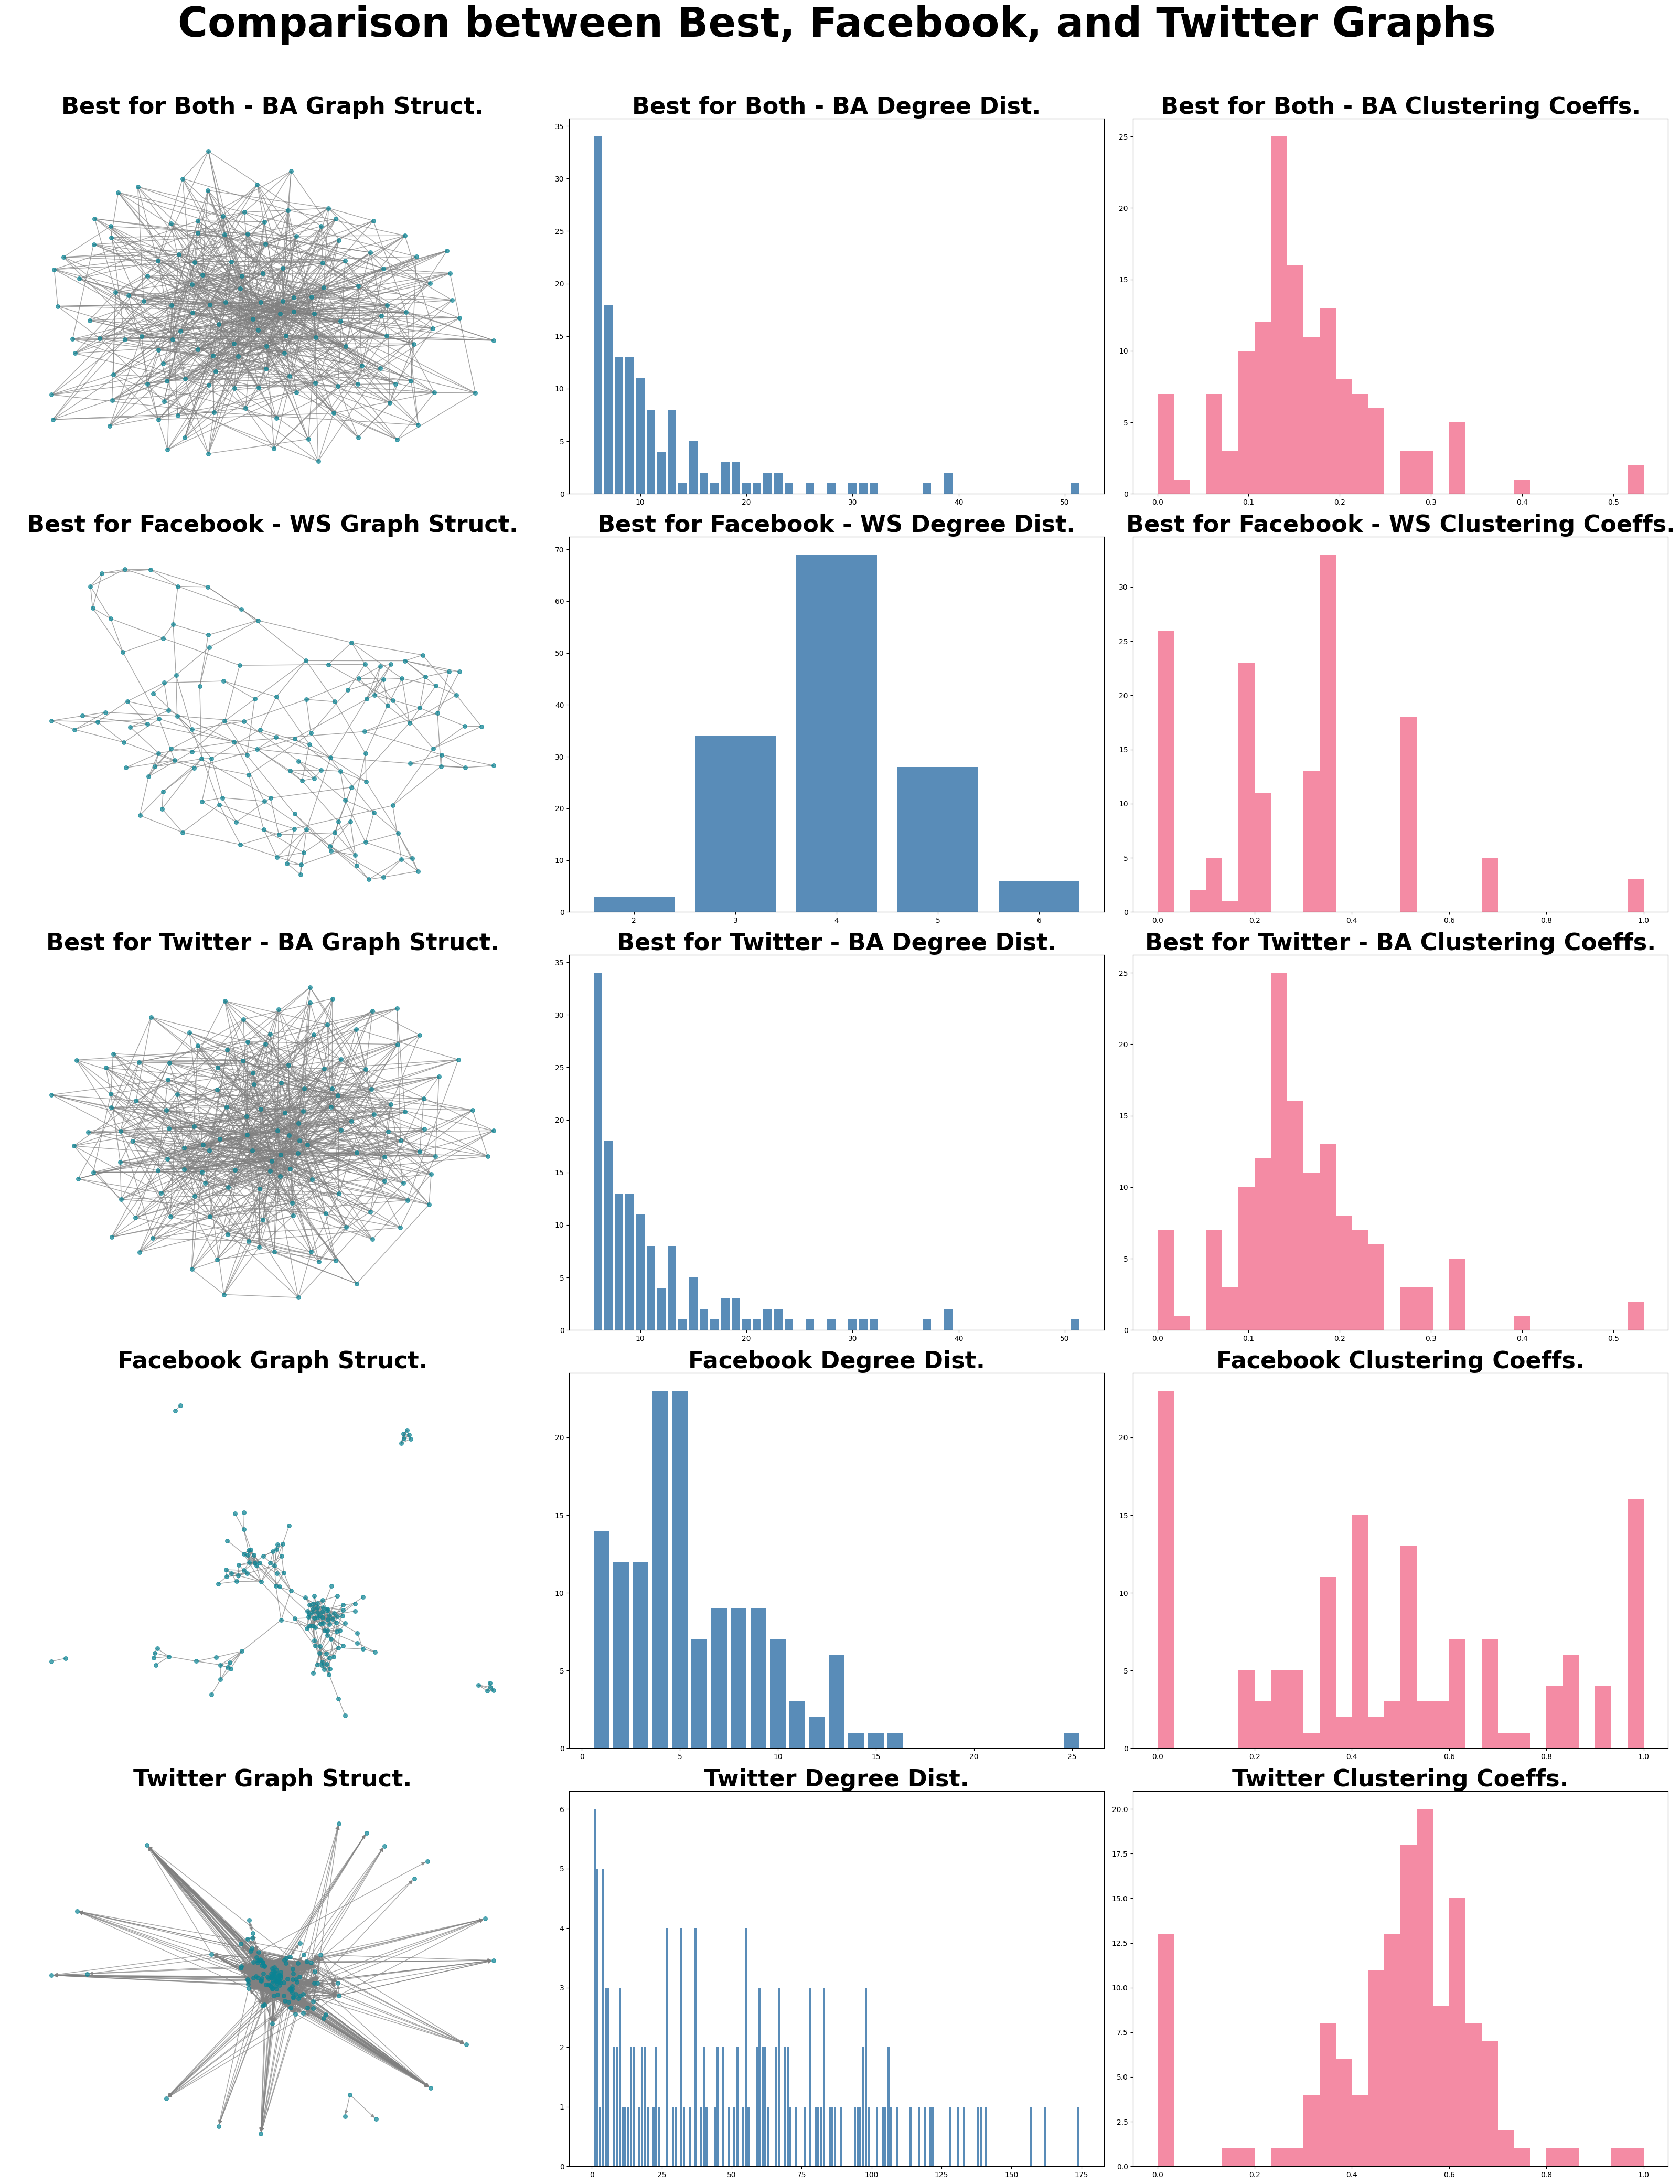

In [45]:
# create subplots: 5 graphs (Best, FB, TW) x 3 plots (structure, degree dist, clustering coeff)
fig, axs = plt.subplots(5, 3, figsize=(32, 40))
fig.text(0.5, 1.03, 'Comparison between Best, Facebook, and Twitter Graphs', 
            ha="center", va="center", fontsize=56, fontweight="bold")
# iterate through all graphs to compare and plot
graphs_to_compare = {
    f"Best for Both - {best_both['model']}": best_both["graph"],
    f"Best for Facebook - {best_fb['model']}": best_fb["graph"],
    f"Best for Twitter - {best_tw['model']}": best_tw["graph"],
    "Facebook": G_fb,
    "Twitter": G_tw
}
for i, (graph_name, graph) in enumerate(graphs_to_compare.items()):
    # graph structure
    plot_graph(graph, axs[i, 0])
    axs[i, 0].set_title(f"{graph_name} Graph Struct.", fontsize=32, fontweight="heavy")
    # degree distribution
    plot_degree_distribution(graph, axs[i, 1])
    axs[i, 1].set_title(f"{graph_name} Degree Dist.", fontsize=32, fontweight="heavy")
    # clustering coefficient distribution
    plot_clustering_coefficients(graph, axs[i, 2])
    axs[i, 2].set_title(f"{graph_name} Clustering Coeffs.", fontsize=32, fontweight="heavy")
plt.tight_layout()
plt.show()

We used three key metrics to compare the similary scores between randomly generated graphs and Facebook and Twitter graphs: 

1. Degree distribution, weight $0.4$.
2. Clustering coefficient, weight $0.4$.
3. Average shortest path length, weight $0.2$.

The final metric is the weighted sum of these metrics. Note that all of the metrics are scaled to $0-1$ range before weighted sum.

Based on these metrics, we come to a conclusion that the most similar graph to both Facebook and Twitter networks is a graph based on the `BA` model with `m=6` and `m0=7`, with `m0` constructed from a *random* graph. The same graph is also the most similar to the Twitter network only. However, it turns out that the randomly generated graph based on the `WS` model is the most similar to the Facebook graph.

This makes sense based on the characteristics of each network. If we analyze the plots, we can notice that the degree distribution of Twitter is closer to a power-law distribution, while the degree distribution of Facebook looks more like an exponential distribution. If we look at the clustering coefficients, Twitter's clustering coefficients tend to be lower compared to Facebook's, where the coefficients are more evenly spread from $0$ to $1$. Remember that from theory we know that:
1. **BA scale-free networks** observe power-law degree distributions and small clustering coefficients.
2. **WS small-world networks** observe exponential degree distributions and large clustering coefficients.

This explains why the `BA` model fits the Twitter network best, while the `WS` model fits the Facebook network. Also, notice how the hub nodes are more common in the Twitter network, which aligns with the fact how the graphs based on the `BA` model are created.

Naturally, to make our conclusion stronger, we would need to explore a wider range of parameters for the random graphs and generate much more random graphs for comparison.